## LSA(잠재 의미 분석)

사이킷런에서는 Twenty Newsgroups이라고 불리는 20개의 다른 주제를 가진 뉴스그룹 데이터를 제공합니다. 여기서는 LSA를 사용해서 문서의 수를 원하는 토픽의 수로 압축한 뒤에 각 토픽당 가장 중요한 단어 5개를 출력하는 실습으로 토픽 모델링을 수행합니다.

- 데이터 : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('샘플의 수 :',len(documents))

샘플의 수 : 11314


In [3]:
print(dataset.target_names) # 분류 카테고리

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:
print(dataset.DESCR) # 데이터 설명

In [ ]:
# 첫번째 샘플 확인하기
print(documents[0])

In [ ]:
# 카테고리 확인하기
print(dataset.target_names[dataset.target[0]])

talk.politics.mideast


### 1. 텍스트 전처리

In [4]:
import re

In [5]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].apply(lambda x : re.sub("[^a-zA-Z ]", "", x))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [6]:
news_df['clean_doc'][0]

'well im not sure about the story nad it did seem biased whati disagree with is your statement that the us media is out toruin israels reputation that is rediculous the us media isthe most proisraeli media in the world having lived in europei realize that incidences such as the one described in theletter have occured the us media as a whole seem to try toignore them the us is subsidizing israels existance and theeuropeans are not at least not to the same degree so i thinkthat might be a reason they report more clearly on theatrocitieswhat is a shame is that in austria daily reports ofthe inhuman acts commited by israeli soldiers and the blessingreceived from the government makes some of the holocaust guiltgo away after all look how the jews are treating other raceswhen they got power it is unfortunate'

### 2. TF-IDF 벡터화

In [7]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, # 상위 1,000개의 단어를 보존
max_df = 0.5, smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X.shape)

TF-IDF 행렬의 크기 : (11314, 1000)


In [ ]:
X

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 249824 stored elements in Compressed Sparse Row format>

### 3. LSA
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

위에서 만든 TF-IDF 행렬을 SVD로 분해해보겠습니다.
이때, 토픽의 숫자를 정해야 하는데, 기존 뉴스그룹 데이터의 카테고리가 20개이기 때문에, 20개의 토픽을 가졌다고 가정하고 토픽모델링을 시도해보겠습니다.
- n_components : 토픽의 숫자

In [8]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)

TruncatedSVD(n_components=20, n_iter=100, random_state=122)

In [ ]:
svd_model.components_.shape # V.T : 토픽의 수 t x 단어의 수 1000

(20, 1000)

In [ ]:
svd_model.components_ # V.T : 토픽의 수 t x 단어의 수 1000

array([[ 0.0127564 ,  0.04550163,  0.01929891, ...,  0.01521581,
         0.04915142,  0.01626042],
       [-0.00304867,  0.02515408, -0.0189763 , ..., -0.01722622,
        -0.02411805, -0.00854918],
       [ 0.00243011,  0.00858544,  0.02190316, ..., -0.01500173,
        -0.02561598, -0.00405654],
       ...,
       [ 0.00990991,  0.00143978,  0.00585319, ...,  0.00600346,
        -0.00628208, -0.00169151],
       [ 0.00013522,  0.00818153, -0.00059985, ..., -0.00634445,
         0.02770258,  0.00457671],
       [ 0.00361947,  0.00307732,  0.01386232, ...,  0.00081889,
         0.05658633, -0.01556186]])

In [ ]:
# 첫번째 토픽의 단어 분포
svd_model.components_[0]

In [ ]:
# 숫자들 중 크기 순서대로 정렬 -> 인덱스
svd_model.components_[0].argsort()[::-1][:10]

array([240, 441, 479, 450, 626, 882, 399, 237, 346, 920])

In [ ]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names_out()

In [ ]:
# 첫번째 토픽의 단어들 중 가장 중요한 단어
n = 10
idx_10 = svd_model.components_[0].argsort()[::-1][:n]
terms[idx_10]

array(['dont', 'just', 'like', 'know', 'people', 'think', 'im', 'does',
       'good', 'use'], dtype=object)

In [ ]:
terms = vectorizer.get_feature_names_out() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[::-1][:n]])
get_topics(svd_model.components_,terms)

Topic 1: [('dont', 0.19543), ('just', 0.19242), ('like', 0.19139), ('know', 0.18386), ('people', 0.16936)]
Topic 2: [('windows', 0.23912), ('use', 0.18177), ('card', 0.16098), ('drive', 0.15685), ('email', 0.15325)]
Topic 3: [('god', 0.43001), ('does', 0.24053), ('jesus', 0.15928), ('know', 0.15367), ('people', 0.1438)]
Topic 4: [('know', 0.48202), ('im', 0.31367), ('dont', 0.25983), ('does', 0.24922), ('just', 0.1871)]
Topic 5: [('just', 0.35025), ('dont', 0.26071), ('use', 0.16317), ('people', 0.15091), ('key', 0.12253)]
Topic 6: [('drive', 0.37209), ('just', 0.33664), ('god', 0.29951), ('scsi', 0.1501), ('mb', 0.14764)]
Topic 7: [('im', 0.30143), ('email', 0.23481), ('new', 0.21758), ('car', 0.15909), ('looking', 0.13174)]
Topic 8: [('im', 0.44547), ('windows', 0.17239), ('god', 0.16803), ('file', 0.16448), ('window', 0.12788)]
Topic 9: [('just', 0.5207), ('like', 0.33852), ('does', 0.31155), ('key', 0.10372), ('god', 0.0844)]
Topic 10: [('like', 0.59492), ('think', 0.1807), ('car',

## LDA
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

### 1. 벡터화

전처리는 LSA과정과 동일함으로 생략하고 바로 벡터화부터 진행하겠습니다.

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, # 상위 1,000개의 단어를 보존
max_df = 0.5, smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X.shape)

TF-IDF 행렬의 크기 : (11314, 1000)


In [10]:
from sklearn.decomposition import LatentDirichletAllocation
# 모델 객체 생성
lda_model = LatentDirichletAllocation(n_components=20, random_state=777)

In [11]:
# fit transfom
lda_model.fit(X)

LatentDirichletAllocation(n_components=20, random_state=777)

In [ ]:
X

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 249824 stored elements in Compressed Sparse Row format>

In [ ]:
lda_model.perplexity(X)

3313.5367646963305

In [ ]:
scores = []
for i in range(2, 20):
    lda_model = LatentDirichletAllocation(n_components=i, random_state=1004)
    lda_model.fit(X)
    scores.append(lda_model.perplexity(X))

In [ ]:
scores

[963.329335769336,
 1135.3932729191336,
 1312.6130654413046,
 1445.7234344771005,
 1593.9694591687098,
 1691.820082351976,
 1778.8351820794544,
 1945.1528488796039,
 2047.3121735700752,
 2181.4664952556404,
 2323.3838898484432,
 2379.1629502733686,
 2519.7671787892928,
 2696.7678712277707,
 2741.3411506059356,
 2915.2913031144567,
 3140.6875821165468,
 3130.1640714345745]

In [ ]:
from matplotlib import pyplot as plt

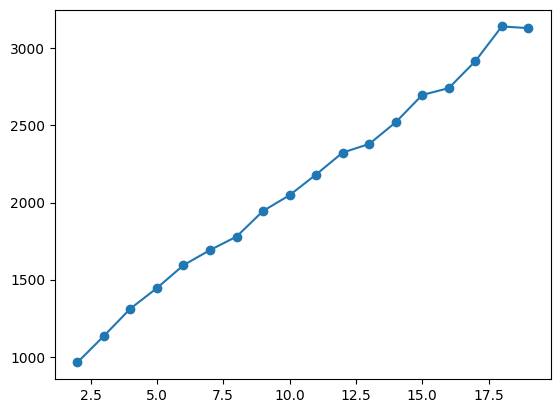

In [ ]:
plt.plot(range(2, 20), scores, 'o-')

In [12]:
print(lda_model.components_)
print(lda_model.components_.shape)

[[0.05       1.55208978 2.97391732 ... 1.58456805 1.80688019 0.63657143]
 [0.05       4.47822817 0.66564391 ... 0.05       2.17562451 0.12261933]
 [0.05000001 7.92076345 0.05000001 ... 1.24504009 7.05032263 6.87188656]
 ...
 [0.32351857 2.82092377 0.05       ... 0.05       4.32778594 0.54515457]
 [0.05       0.05       1.63634901 ... 0.05       0.05       0.05      ]
 [0.05       1.32499315 0.05       ... 0.05013512 0.05001047 0.54918849]]
(20, 1000)


In [13]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names_out()

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda_model.components_,terms)

Topic 1: [('israel', 42.12), ('israeli', 31.44), ('jews', 27.35), ('jewish', 24.14), ('war', 23.77)]
Topic 2: [('drivers', 29.88), ('windows', 29.8), ('mouse', 27.61), ('driver', 26.48), ('mb', 24.66)]
Topic 3: [('car', 65.52), ('bike', 55.86), ('like', 39.88), ('just', 38.73), ('end', 31.79)]
Topic 4: [('thanks', 41.23), ('know', 32.0), ('ftp', 28.21), ('does', 23.08), ('anybody', 21.78)]
Topic 5: [('posting', 18.66), ('orbit', 15.47), ('launch', 15.25), ('satellite', 11.05), ('space', 10.98)]
Topic 6: [('file', 44.87), ('files', 37.51), ('windows', 36.28), ('program', 30.52), ('dos', 21.24)]
Topic 7: [('drive', 63.79), ('disk', 29.34), ('drives', 27.9), ('hard', 23.94), ('format', 23.56)]
Topic 8: [('game', 74.92), ('team', 74.08), ('year', 57.77), ('games', 54.19), ('play', 47.28)]
Topic 9: [('god', 115.16), ('people', 96.02), ('think', 61.17), ('dont', 60.62), ('jesus', 58.56)]
Topic 10: [('try', 26.68), ('youre', 26.6), ('dont', 22.7), ('just', 19.95), ('going', 19.51)]
Topic 11: 

In [14]:
# 시각화
# LDAvis 는 토픽 모델링에 자주 이용되는 Latent Dirichlet Allocation (LDA) 모델의 학습 결과를 시각적으로 표현하는 라이브러리입니다
!pip install -U pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 43.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.0 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 

In [15]:
# LDA 시각화를 진행해봅시다.
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(
                        lda_model = lda_model,
                       dtm = X,
                       vectorizer = vectorizer,
                       mds='tsne')
pyLDAvis.display(vis)


BrokenProcessPool: ignored

LDAvis 는 두 가지 정보를 출력합니다. 첫째는 HTML 의 좌측에 출력되는 topic 의 2 차원 embedding vector 입니다. 비슷한 위치에 존재하는 토픽들은 서로 비슷한 문맥을 지니고 있습니다. 그리고 둘째는 오른쪽에 출력되는 각 토픽의 키워드 입니다.

좌측의 원들은 각각의 20개의 토픽을 나타냅니다.
각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줍니다.만약 두 개의 원이 겹친다면, 이 두 개의 토픽은 유사한 토픽이라는 의미입니다.
각 원을 클릭하면 우측에 해당 토픽에 관한 정보가 나타납니다

LDAvis 에서는 두 관점의 중요도를 사람이 직접 정할 수 있도록 하였습니다. 우측상단에 λ 라는 값이 있습니다. 이 값은 [0, 1] 사이에서 조절가능한 값입니다. 그리고 그 아래 키워드 랭킹은 다음의 점수로 계산됩니다. λ를 1 로 설정하면 토픽 별로 가장 자주 등장하는 단어들을 우선적으로 키워드로 선택한다는 의미이며, λ 를 0 에 가깝게 설정할수록 토픽 간에 차이가 많이 나는 단어를 선택한다는 의미입니다. https://lovit.github.io/nlp/2018/09/27/pyldavis_lda/

---
- Reference : https://wikidocs.net/24949